In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils
from snntorch import functional as SF
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import itertools
import cv2
from tqdm import tqdm
# from collections import defaultdict

from module.custom_data import LoadDataset
from module import custom_data, network, compute_loss, view
from module.const import *

import matplotlib.pyplot as plt
from IPython.display import HTML

from collections import defaultdict


# いろいろ定義

In [3]:

train_dataset = LoadDataset(processed_event_dataset_path=PROCESSED_EVENT_DATASET_PATH, raw_event_dir=RAW_EVENT_PATH, accumulate_time=ACCUMULATE_EVENT_MICROTIME , input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH,train=True)
test_dataset = LoadDataset(processed_event_dataset_path=PROCESSED_EVENT_DATASET_PATH, raw_event_dir=RAW_EVENT_PATH, accumulate_time=ACCUMULATE_EVENT_MICROTIME , input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, train=False)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TEST, collate_fn=custom_data.custom_collate, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, collate_fn=custom_data.custom_collate, shuffle=False,)



net = NET
net.network.load_state_dict(torch.load(MODEL_PATH))
# corract_rate  = 0.5
events, _ = train_dataset[0]
num_steps = events.shape[0]



# 出力結果の解析
危険とみなすスパイク数の閾値を変化させたときの、出力画像やiouを算出する


  0%|          | 0/600 [00:00<?, ?it/s]

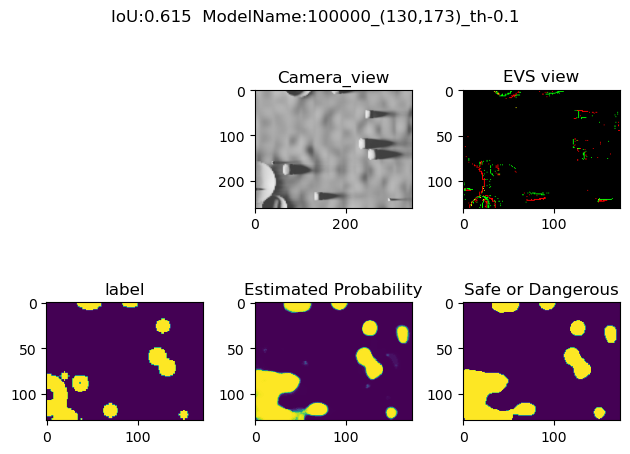

  0%|          | 0/600 [00:02<?, ?it/s]


In [4]:
# def get_first_frame(video_path):
#     cap = cv2.VideoCapture(video_path)
#     _, frame = cap.read()
#     return frame

# def get_first_events(events):
#     events = events.to('cpu')
#     if BOOL_DISTINGUISH_EVENT:
#         first_events = np.zeros((INPUT_HEIGHT, INPUT_WIDTH, 3)) # bgr
#         first_events[:,:,0] = events[0,0,0] * 255# r 
#         first_events[:,:,1] = events[0,0,1] * 255
#         return first_events
def save_img(number, events, pred_pro, label, iou, pdf_output):
    # label = label.reshape((pixel, pixel)).to('cpu')
    # print(pred_pro.shape)
    number_str = str(number).zfill(5)
    num_steps = len(pred_pro)
    nrows = 2
    ncols = 5
    fig = plt.figure()
    # ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)


    # dem_filename = f'dem_{str(number).npy}'
    # dem_path = os.path.join(DEM_NP_PATH, dem_filename)
    # dem = np.load(dem_path)
    # ax1.imshow(dem)

    video_filename = f'{number_str}.avi'
    video_path = os.path.join(VIDEO_PATH, video_filename)
    first_frame = view.get_first_frame(video_path) 
    ax2.set_title('Camera_view')
    ax2.imshow(first_frame)

    first_events = view.get_first_events(events) 
    ax3.set_title('EVS view')
    ax3.imshow(first_events)

    label_ =label.reshape((INPUT_HEIGHT, INPUT_WIDTH)).to('cpu')
    ax4.imshow(label_)
    ax4.set_title('label')

    pred_pro_ = pred_pro[:, 1, :, :]
    pred_pro_ = pred_pro_.reshape((INPUT_HEIGHT, INPUT_WIDTH)).to('cpu').detach().numpy().copy()
    ax5.imshow(pred_pro_)
    ax5.set_title('Estimated Probability')

    ax6.imshow(np.where(pred_pro_>=CORRECT_RATE, 1, 0))
    ax6.set_title('Safe or Dangerous')

    fig.suptitle(f"IoU:{round(iou, 3)}  ModelName:{MODEL_NAME}")
    plt.tight_layout()
    # plt.show()
    # exit()
    img_path = os.path.join(RESULT_PATH, f'{str(i).zfill(5)}.png')
    fig.savefig(img_path)
    if pdf_output:
        img_path = os.path.join(RESULT_PATH, f'{str(i).zfill(5)}.pdf')
        fig.savefig(img_path)
    plt.close()

hist = defaultdict(list)
if os.path.exists(RESULT_PATH):
        shutil.rmtree(RESULT_PATH)
os.makedirs(RESULT_PATH)

with torch.no_grad():
    net.network.eval()
    for i, (events, label) in enumerate(tqdm(iter(test_loader))):
        events = events.to(DEVICE)
        label = label.to(DEVICE)
        batch = len(events[0])
        # print(events.shape)# TBCHW
        # events = events.reshape(num_steps, batch, INPUT_CHANNEL, INPUT_HEIGHT, INPUT_WIDTH)
        pred_pro = net(events)
        
        iou = compute_loss.culc_iou(pred_pro, label, CORRECT_RATE)

        # pred_pro = compute_loss.show_pred(pred_pro, correct_rate)
        
      
        save_img(i, events, pred_pro, label,  iou, pdf_output=False)
        # break


## 閾値毎のIOUの平均算出

In [5]:
for key, value in hist.items():
    print(f'IoU_{key}:{np.mean(value)}')